# Project Notebook
## Authors : Alex CAHILL and Vincent HERFELD

## Kernel Regression 

### A. 1D-regression on synthetic data

First we would like to see how kernel regression functions. To do so we will apply the following method developped in the article :

Given a set of observations $\{t_i, y_i\}_{i=1,..,N}$ drawn from an unknown distribution $f_{T,Y}$ where $Y$ is dependant of $T$ and $T$ is independant of $Y$, so we model this relationship with $y_i = m(t_i) + \epsilon_i$ where $\epsilon_i$ is a random error. In our setting $m$ is the conditional expectation : $m(t) = \mathbb{E}[Y | T = t] = \int_{\mathbb{R}} y \frac{f_{T,Y}(t,y)}{f_T(t)} dy$. 

Since the above densities are unknown we will estimate $m$ with the Nadaraya-Watson kernel regression estimator :

$\hat{m}(t) = \frac{\sum_{i=1}^{N} K_h(t-t_i)y_i}{\sum_{i=1}^{N} K_h(t-t_i)}$ where $K_h$ is a kernel that verifies $\int_{\mathbb{R}} K = 1$ and $K_h(t) = \frac{1}{h}K(\frac{t}{h})$ an example is the gaussian kernel :

$K(t) = \frac{1}{2\pi} \exp(-\frac{t^2}{2})$ and so $K_h(t) = \frac{1}{2\pi h} \exp(-\frac{t^2}{2h^2})$

Let's try this out on synthetic data :

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def K(t,h):
    return 1/(2*np.pi*h) * np.exp(-0.5 * (t**2 / h**2))

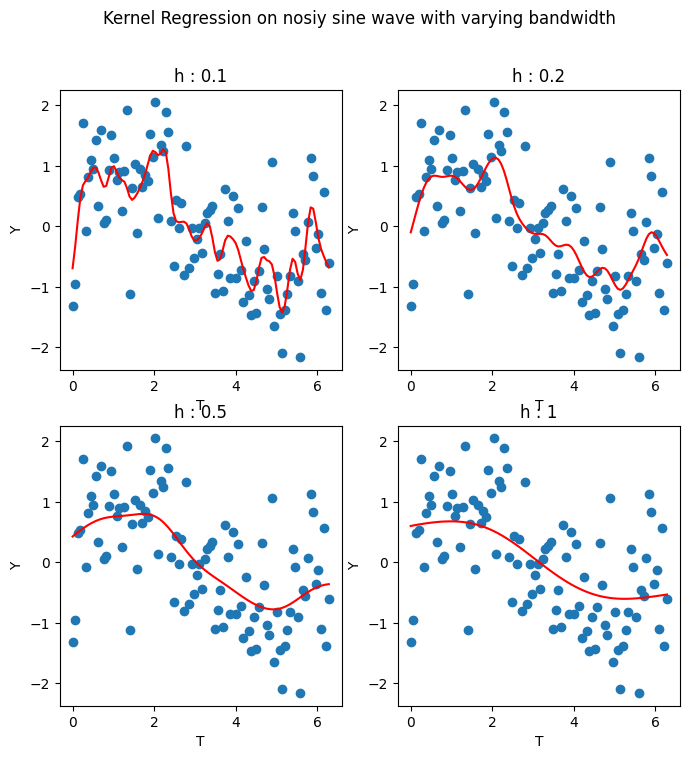

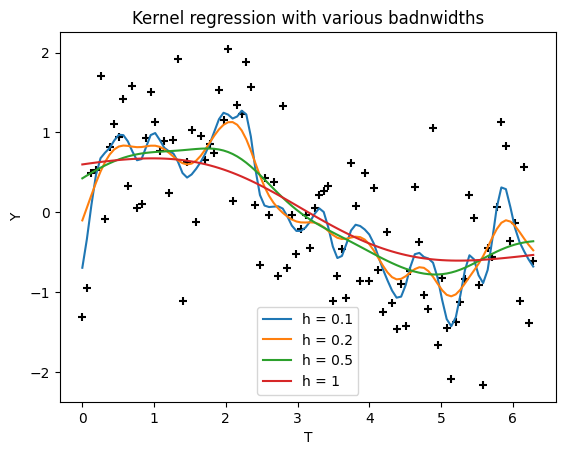

In [3]:
N = 100
T = np.linspace(0, 2*np.pi, N)
Y = np.sin(T) + np.random.normal(size=N)/1.5

H = [0.1,0.2,0.5, 1]

fig, axs = plt.subplots(2,2, figsize = (8,8))
plt.suptitle("Kernel Regression on nosiy sine wave with varying bandwidth")

axs = axs.flatten()
for ax, h in zip(axs,H):
    m_hat = []
    for t in T:
        m_hat.append(np.sum(K(t - T, h)*Y)/ np.sum(K(t - T, h)))
    ax.set_title("h : {}".format(h))
    ax.set_xlabel("T")
    ax.set_ylabel("Y")
    ax.scatter(T, Y)
    ax.plot(T, m_hat, c="red")

plt.show()

plt.figure()
plt.title("Kernel regression with various badnwidths")
plt.xlabel("T")
plt.ylabel("Y")
plt.scatter(T, Y, marker="+",c="k")
for h in H:
    m_hat = []
    for t in T:
        m_hat.append(np.sum(K(t - T, h)*Y)/ np.sum(K(t - T, h)))
    plt.plot(T, m_hat, label="h = {}".format(h))

plt.legend()
plt.show()

So we notice that a higher bandwidth adds smoothness but we capture less variation from the data. 

We now would like to apply this on Riemannian manifolds.

### B. Regression on Riemannian manifolds

In this setting we cannot used what was done above, this is due to the fact that in general a manifold is not a vector space and for instance the sum is not well defined. To express a functionning regression method we need a little more work to be done. 
We give ourselves the observations $\{t_i, p_i\}_{i=1,..,N}$ where again the $(t_i)$ are drawn from a univariate random variable $T$ and this time the $(p_i)$ are points on a manifold $\mathcal{M}$ depending on the (t_i). We model the relationship as is : 

$p_i =$ Exp$_{m(t_i)}(\epsilon_i)$ 

where $m : \mathbb{R} \rightarrow \mathcal{M}$ defines a curve on the manifold $\mathcal{M}$. 

This time $\epsilon_i$ is also an error term but it lies in the tangeant space of the curve : $\epsilon_i \in \mathbf{T}_{m(t_i)}\mathcal{M}$. It is interpreted as the displacement of each $p_i$ from the curve $m$. 
Exp$_{x}(t \times u)$ returns the point on at time $t$ along the geodesic flow on $\mathcal{M}$ beginning at $x$ with initial velocity $u$.

So the expectation we consider is the Fréchet expectation that considers manifold-valued random variables : 

$\mathbb{E}_f[p] = \underset{q \in \mathcal{M}}{\text{argmin}} \int_{\mathcal{M}} d(q,p)^2f(p)$,

where $f$ is a probability density on $\mathcal{M}$ and $d$ is a metric on $\mathcal{M}$.

Again as it was above we do not know the density and thus we will estimate empirically using the expression of the Fréchet mean $\mu = \underset{q \in \mathcal{M}}{\text{argmin}} \frac{1}{N} \sum_{i=1}^{N}d(p,q_i)^2$ and the Nadaraya-Watson kernel regression estimator, the authors call this a $\textit{manifold kernel regression estimator}$ :

$\hat{m}_h(t) = \underset{q \in \mathcal{M}}{\text{argmin}} \frac{\sum_{i=1}^{N} K_h(t-t_i)d(q,p_i)^2}{\sum_{i=1}^{N} K_h(t-t_i)}$

Now according to the manifold on which we are working we must define a specific metric and find a way to minimize the above function. This can be solved in closed form, or with iterative methods like (stochastic) gradient descent amongst others.

Another important question is which bandwidth is the most suited to our specific problem.


### C. Bandwidth selection

The authors mention several methods to select an optimal bandwidth. They give us a classical method that is easily extended to a manifold regression setting, this automatic bandwith selection method relies on least squares cross-validation : 


$\hat{h}_{LSCV} = \underset{h \in \mathbb{R+}}{\text{argmin}} \frac{1}{N} \sum_{i=1}^{N} d(\hat{m}^{i−}(t_i),p_i)^2$

where $\hat{m}^{i−}(t) = \underset{q \in \mathcal{M}}{\text{argmin}} \frac{\sum_{j=1, j \neq i}^{N} K_h(t-t_j)d(q,p_j)^2}{\sum_{j=1,  j \neq i}^{N} K_h(t-t_j)}$.

We understand that $\hat{m}^{i−}$ is the estimator $\hat{m}_h$ where we remove the $i^{th}$ observation.

The authors remind us that this can have multiple local minima and we must give a decision rule for instance choose a smaller $h$ to capture more variation, or a greater one to have a smoother regression.

Let's try to apply this in our synthetic setting in $\mathbb{R}$ where we take $d$ as the euclidian distance. We will not solve an optimisation problem but just try out several $h \in \mathbb{R+}$.

In [4]:
M = np.linspace(-3,3, 30)
H = np.linspace(0.01, 2.5, 50)
h_list = []
for h in H:
    M_i = []
    for i in range(N):
        Y_i = np.delete(Y, i)
        T_i = np.delete(T, i)
        m_hat = []
        for q in M:
            m_hat.append(np.sum(K(T[i] - T_i, h)*(Y_i - q)**2)/ np.sum(K(T[i] - T_i, h)))
        m_hat=np.array(m_hat)
        M_i.append(M[np.argmin(m_hat)])
    h_list.append(np.sum((np.array(M_i) - Y)**2)/N)
h_LSCV = H[np.argmin(h_list)]
print("The decided bandwidth is h = {}".format(h_LSCV))


The decided bandwidth is h = 0.16244897959183677


Let's plot our regression using this bandwidth.

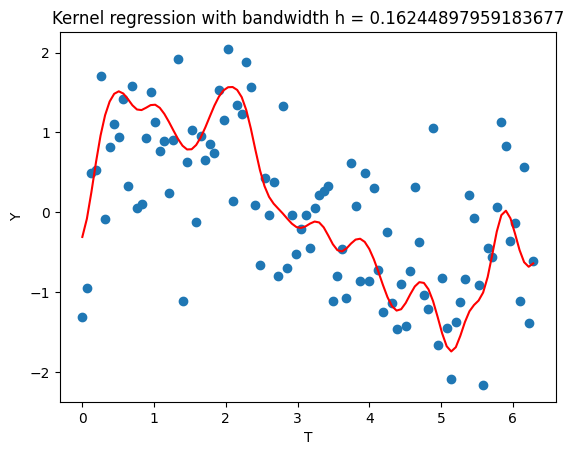

In [5]:
m_hat = []
for t in T:
    m_hat.append(np.sum(K(t - T, h_LSCV)*Y)/ np.sum(K(t - T, h)))
plt.title("Kernel regression with bandwidth h = {}".format(h_LSCV))
plt.xlabel("T")
plt.ylabel("Y")
plt.scatter(T, Y)
plt.plot(T, m_hat, c="red")

### D. Example on the manifold of 3D rotations $SO(3)$

We recall that SO(3) the set of rotation matrices in $\mathbb{R}^3$ is a 3 dimensional smooth manifold (it is a Lie Group). 

Before attacking regression on the set of 3D brain MRIs we would like to apply the above on rotation matrices.  

First we give ourselves an algorithm that, given a matrix, finds the closest rotation matrix to it (maybe it will help out later) ?

In [ ]:
def Mat2RotMat(K):
    U, D, Vt = np.linalg.svd(K, full_matrices=True)
    n = U.shape[1]
    det = np.array([np.linalg.det(U) * np.linalg.det(Vt)])
    S = np.diag(np.concatenate((np.ones(n-1), det)))
    return U @ S @ Vt

Then we define the Exponential and Log maps on this manifold. 

The exponential map is defined as that mapping of a point from the Identity Tangent Plane to the manifold. 
In SO(3) we have that for any rotation $R$, $Exp_R(X) = R Exp_I(R^TX)$ and by definition of a rotation matrix we have that $R^T = R^{-1}$.

Same thing for the Logarithm map that is the inverse of the Exponential map, $Log_R(X) = R Log_I(R^TX)$.

In the rest, we will not note the $_I$ and only consider the maps starting in $I$.

We also recall that a geodesic $\gamma$ starting at matrix $R \in SO(3)$ with initial velocity (tangent vector)  $Y = RX$ is $\gamma(t) = Exp_R(tY) = R.Exp(tR^TRX) = R.Exp(tX)$.  We also note that there are instabilities when Rotations are close to identity and reflections, so we will first try not to consider these. 

In [ ]:
def Exp(X):
    theta = np.sqrt(np.trace(X.T @ X)/2)
    if theta == 0:
        return np.eye(X.shape[0], X.shape[1])
    else:
        return np.eye(X.shape[0], X.shape[1]) + np.sin(theta) * X / theta + (1 - np.cos(theta))  * X**2 / theta**2


def Log(U):
    theta = np.arccos(0.5* (np.trace(U) - 1))
    if theta == 0:
        return np.eye(X.shape[0], X.shape[1])
    else:
        return theta * (U - U.T) / (2 * np.sin(theta))

We then give ourselves a distance metric on $SO(3)$, $d(R_1, R_2) = \|Log(R_1^{-1}R_2)\|$. And we shall solve the minimization problem with gradient descent. So given rotation data $\{t_i,R_i\}_{i=1,...,N}$ and a fixed $t$, we will calculate the Nadaray weights, $w_i(t) = \frac{K_h(t - t_i)}{\sum_{j=1}^{N} K_h(t - t_j)}$ and then minimize the function $f_t(R, \{w_i, R_i\}) = \sum_{i=1}^{N}w_i(t)d(R,R_i)^2$ over the variable $R$. To simplify the expression of the gradient we will multiply by $1/2$.

And so the gradient is $\nabla_R f_t(R) = -\sum_{i=1}^{N}w_i R Log(R^{-1}R_i)$ and since we consider gradient descent on a manifold, instead of doing $\hat{R}_{k+1} =  \hat{R}_{k} - \eta \nabla_{\hat{R}_{k}}f(\hat{R}_{k})$ that is not well defined, so we remind ourselves that moving from an initial point $R$ by a certain amount $\epsilon$ according to a geodesic is exactly the value at time $t = 1$ of $\gamma$ starting at $R$ with initial velocity $\epsilon$.

So in our case we take $R= \hat{R}_k$ and the initial velocity is $- \eta \nabla_{\hat{R}_{k}}f(\hat{R}_{k}) = RX$ where $X = - \eta R^{-1}\nabla_{\hat{R}_{k}}f(\hat{R}_{k})$.

So finally :

$\hat{R}_{k+1} = \gamma_{(R_k, X)}(1) = R_kExp(1 \times X)) = \hat{R}_{k}Exp(- \eta \hat{R}_{k}^{-1}\nabla_{\hat{R}_{k}}f(\hat{R}_{k}))$.

Remark that the authors have forgotten to put this $\eta$ term in the gradient descent and thus do not have a converging algorithm, $\eta$ must verify the hypothesis for the step sizes on gradient descent which are non sommable but square sommable, numerically we can give ourselves small enough step sizes.

Let's implement this :

In [ ]:
def distance(R1, R2):
    #distance on the rotation matrix manifold
    return np.linalg.norm(Log(np.linalg.inv(R1) @ R2))

def grad(R, w, Rj):
    g = []
    N = len(w)
    for i in range(N):
        g.append(w[i] * R @ Log(np.linalg.inv(R) @ Rj[i]))
    return -np.array(g).sum(axis=0)

def gradient_descent(eta, w, Rj, N_ITER = 30):
    eps = 0.01
    #initialise random rotation matrix
    R = Mat2RotMat(np.random.normal(loc = 5, size=(3,3)))
    vt = []
    for k in range(N_ITER):
        #gradient descent step
        R = R @ Exp(-eta * np.linalg.inv(R) @ grad(R,w,Rj))
        v = 0
        #calculate the objective function on the newly found matrix, to check if we are minimizing well
        for i in range(N):
            v += K(t - Tj[i], h) * distance(R, Rj[i]) 
            v = np.exp(np.log(v + eps) - np.log(np.sum(K(t - Tj, h)) + eps))
        vt.append(v)
    return R, vt

We need to synthesis data to apply this regression. We will use our Mat2RotMat function.

In [ ]:
N = 100
Tj = np.random.randint(0,200,size=N) #our {t_i}  
Rj = []
for t in Tj:
    Rj.append(Mat2RotMat(np.random.normal(loc = t, size=(3,3))))
Rj = np.array(Rj) #and our {R_i}

Now let's try the regression task :

In [ ]:
h = 0.2
T = np.arange(0, 200)
m_hat = []
v = []
eta = 0.00001
eps = 1e-16
for t in T:
    #calculate weights
    w = []
    for i in range(N):
        w.append(np.exp(np.log(K(t - Tj[i], h) + eps) - np.log(np.sum(K(t - Tj, h)) + eps)))
    w = np.array(w)
    #apply gradient descent at each time stamp
    m, vt = gradient_descent(eta, w, Rj)
    m_hat.append(m)
    v.append(vt)
    
m_hat = np.array(m_hat)

In [ ]:
fig,axs = plt.subplots(2,2)
axs = axs.flatten()
k = 20
for i,vt in enumerate(v[k:k+4]):
    axs[i].plot(vt)

By modifying k we can observe 4 consecutive graphs associated to the value of $f$ at time $t + i$ and we observe that the gradient descent is effective : either reduces or keeps constant the value of $f$.

This value is not necessarily going to be small, this can be due to the particular properties of this manifold, that seems hard to visualise.

### D - Kernel Regression for Images on a Manifold

An important idea in image comparison is that we cannot just compare pixel values between 2 images, this doesn't consider any shapes that are present in the image. For example a rigid transformation (simple translation in space) will cause the images to be very different pixel wise where actually they represent the same object. 

The idea that is used to do this efficiently is to consider diffeomorphisms that transform images according to their coordinate system : 

$I_\phi(x) = I(\phi^{-1}(x))$ where $x \in \Omega \subset \mathbb{R}^3$ and $I(x)$ is the value of the image $I$ at that voxel $x$ and $\phi : \Omega \rightarrow \Omega$ is a diffeomorphism (differentiable, bijective and its inverse is differentiable) from the coordinate space to itself. 

So to compare 2 images we will examinate how much we need to difform them to align them in their coordinate space. 

In our setting the authors consider a particular case that comes from the theory of large deformation diffeomor-
phisms such that these diffeomorphisms $\phi$ are indexed by a time index $s \in [0,1]$ and are solutions to the Lagrangian ODEs $\frac{d\phi_s}{ds}(x) = v_s(\phi_s(x))$ where $v_s$ is seen as a velocity.

And the introduced metric is : $d_{\mathcal{H}}(e, \phi)^2 = \underset{v:\dot{\phi}_s=v_s(\phi_s)}{min} \int_0^1 \|v_s\|_V^2 ds$

### E - Testing the algorithm on synthetic 2D images

We consider the same example used in the article, but modify a little the considered functions. We will build images of bulleyes that are defined by 3 radii each following a certain model :
$$
\begin{align*}
r_1(t_i) &= f_1(t_i) + ε_i + ε_{i,1} \\
r_2(t_i) &= f_2(t_i) + ε_i + ε_{i,2} \\
r_3(t_i) &= f_3(t_i) + ε_i + ε_{i,3}\\
\end{align*}
$$
subject to
$r_1(t)<r_2(t)<r_3(t)$ forall $t∈[0,1]$.

We will build 2 cohorts of images where one contains more noise than the other.

So we consider that the noise variables are Gaussian noise: 

>For cohort $B_1$ we consider $ε_i ∼ \mathcal{N}(μ = 0,σ^2 = 4$ pixels) and $ε_{i,1},ε_{i,2},ε_{i,3} ∼ \mathcal{N}(μ = 0,σ^2 = 1$ pixels).

>For cohort $B_2$ we consider $ε_i ∼ \mathcal{N}(μ = 0,σ^2 = 16$ pixels) and $ε_{i,1},ε_{i,2},ε_{i,3} ∼ \mathcal{N}(μ = 0,σ^2 = 4$ pixels).

In [ ]:
def f1(x):
    return -10 / (1 + np.exp(-(20 * x - 10))) + 45

def f2(x):
    freq = 1.1
    phi = 1.2
    return 5* np.sin(2 * np.pi * x * freq + phi) + 65

def f3(x):
    return 10*x + 75

In [ ]:
N = 100 #number of images 
T = np.linspace(0, 1, N) #time index
B_1 = np.empty((3,N)) # first cohort 
B_2 = np.empty((3,N)) # second cohort

eps_i = np.random.normal(loc = 0, scale = 1, size = N) # cohort 1
B_1 = np.array([f1(T) + eps_i + np.random.normal(loc = 0, scale = 1, size = N), f2(T) + eps_i + np.random.normal(loc = 0, scale = 1, size = N), f3(T) + eps_i + np.random.normal(loc = 0, scale = 1, size = N)])
    
eps_i = np.random.normal(loc = 0, scale = 4, size = N) # cohort 2
B_2 = np.array([f1(T) + eps_i + np.random.normal(loc = 0, scale = 4, size = N), f2(T) + eps_i + np.random.normal(loc = 0, scale = 4, size = N), f3(T) + eps_i + np.random.normal(loc = 0, scale = 4,size = N)])

print(B_1.shape)
    
colors = ["red", "green", "blue"]
mark = ['P', 'o', "<"]

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 5))
F = [f1(T), f2(T), f3(T)]
for i in range(3):
    ax1.scatter(T, B_1[i], facecolor='none', edgecolor= colors[i], marker = mark[i])
    ax1.plot(T, F[i], label="f{}".format(i + 1), c = colors[i])
    ax1.set_title("Cohort $B_1$")
    ax1.set_xlabel("t")
    ax1.set_ylabel("r")
    ax1.legend()
    
    ax2.scatter(T, B_2[i], facecolor='none', edgecolor= colors[i], marker = mark[i])
    ax2.plot(T, F[i], label="f{}".format(i + 1), c = colors[i])
    ax2.set_title("Cohort $B_2$")
    ax2.set_xlabel("t")
    ax2.set_ylabel("r")
    ax2.legend()
plt.show()

In [ ]:
image_array_B1 = []
image_array_B2 = []
# Create N bullseye images and store in an array
for i in range(N):
    #GENERATE B1
    fig, ax = plt.subplots(figsize=(256/100, 256/100))  # Set figure size for 256x256 image
    ax.set_aspect('equal')
    ax.set_xlim([-100, 100])
    ax.set_ylim([-100, 100])
    ax.set_facecolor('black')  # Set background color to black
    fig.patch.set_facecolor('black')
    ax.grid(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

    
    inner_circle = plt.Circle((0, 0), B_1[0, i], color = "black", alpha =0.5)
    annulus_circle = plt.Circle((0, 0), B_1[1, i],  color='white')
    outer_circle = plt.Circle((0, 0), B_1[2, i], color='white', alpha=0.4)
    ax.add_patch(outer_circle)
    ax.add_patch(annulus_circle)    
    ax.add_patch(inner_circle)
    ax.set_xticklabels([])  # Remove x-axis tick labels
    ax.set_yticklabels([])  # Remove y-axis tick labels
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
      

    # Convert plot to a NumPy array and store in the list
    fig.canvas.draw()
    image_np = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]   # Exclude alpha channel for grayscale
    gray_image = np.dot(image_np[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale
    gray_image[gray_image > 100] += np.random.normal(scale = 40, size = gray_image[gray_image > 100].shape)
    image_array_B1.append(gray_image)
    plt.close()
    
    #GENERATE B2
    fig, ax = plt.subplots(figsize=(256/100, 256/100))  # Set figure size for 256x256 image
    ax.set_aspect('equal')
    ax.set_xlim([-100, 100])
    ax.set_ylim([-100, 100])
    ax.set_facecolor('black')  # Set background color to black
    fig.patch.set_facecolor('black')
    ax.grid(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

    
    inner_circle = plt.Circle((0, 0), B_2[0, i], color = "black", alpha =0.5)
    annulus_circle = plt.Circle((0, 0), B_2[1, i],  color='white')
    outer_circle = plt.Circle((0, 0), B_2[2, i], color='white', alpha=0.4)
    ax.add_patch(outer_circle)
    ax.add_patch(annulus_circle)    
    ax.add_patch(inner_circle)
    ax.set_xticklabels([])  # Remove x-axis tick labels
    ax.set_yticklabels([])  # Remove y-axis tick labels
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
      

    # Convert plot to a NumPy array and store in the list
    fig.canvas.draw()
    image_np = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]   # Exclude alpha channel for grayscale
    gray_image = np.dot(image_np[..., :3], [0.2989, 0.5870, 0.1140])  # Convert to grayscale
    gray_image[gray_image > 100] += np.random.normal(scale = 40, size = gray_image[gray_image > 100].shape)
    image_array_B2.append(gray_image)
    plt.close()

# Convert the list of images to a NumPy array
image_array_B1 = np.array(image_array_B1)
image_array_B2 = np.array(image_array_B2)

print(image_array_B1.shape) 
print(image_array_B2.shape) 

We show the images from cohort B1 where they are indexed by time starting at top left corner to bottom right. 

In [ ]:
T_j = np.linspace(0, N-1, 5 * 10,dtype=int)
fig,ax = plt.subplots(5, 10, figsize = (30,15))
ax = ax.flatten()
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)  # Remove all margins
for i,t in enumerate(T_j):
    ax[i].imshow(image_array_B1[t], cmap='gray')
    ax[i].axis('off')  # Turn off axis
fig.savefig("BullsEyes.jpg")

And here is the cohort B2

In [ ]:
fig,ax = plt.subplots(5, 10, figsize = (30,15))
ax = ax.flatten()
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)  # Remove all margins
for i,t in enumerate(T_j):
    ax[i].imshow(image_array_B2[t], cmap='gray')
    ax[i].axis('off')  # Turn off axis

Now that the data set is synthesised we can implement the method used by the authors. This consists in regressing a population representative for different values of time. The result will thus be an estimation of the true radii that generated the data. 


So we recall the regression problem in this image setting : 

$\hat{I}_h(t) = \underset{I \in \mathcal{I}}{\text{argmin}} \frac{\sum_{i=1}^{N} K_h(t-t_i)d_{\mathcal{I}}(I,I_i)^2}{\sum_{i=1}^{N} K_h(t-t_i)}$

where $d_{\mathcal{I}}(I,J)^2 = \underset{v:\dot{\phi}_s = v_s(\phi_s)}{min} \int_0^1 \|v_s\|^2_V ds + \frac{\|I(\phi^{-1}) - J\|^2_{L_2}}{\sigma^2}$ 

the minimization problem to calculate the distance between two images is solved by finding the diffeomorphism that best matches I with J in terms of $L_2$ norm (pixel-wise) but that does it in a minimal flow way, ie the first term penalizes important flows that are described by the Sobolev norm (penalizes the successive derivatives).

So to solve the regression problem we must be able to find the distance between 2 images and then we can consider the regression algorithm. 

The authors mention an LDDMM algorithm to calculate the distance and they consider an iterative greedy algorithm that solves the regression. 

In [ ]:
def deform_image(f_inv, I):
    height, width = I.shape
    deformed_image = I.copy()
    for x in range(I.shape[0]):
        for y in range(I.shape[1]):
            if f_inv(x,y)[0] < width and f_inv(x,y)[1] < height and f_inv(x,y)[0] >= 0 and f_inv(x,y)[1] >= 0:
                deformed_image[x,y] = I[f_inv(x,y)]
            else:
                deformed_image[x,y] = 0
    return deformed_image

In [ ]:
def f_inv(x,y):
    return (int(x + 10) , int(y*2 - 50))


I = image_array_B1[0]
deformed_image = deform_image(f_inv, I)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(I, cmap="gray")  # Show the original image
ax1.set_title("Original image")
ax2.imshow(deformed_image, cmap="gray")  # Show the deformed image
ax2.set_title("Deformed image")

plt.show() # Show the deformed image


Unfortunately we were unable to implement a functionning LDDMM algorithm to solve the regression task. We leave here a version of the objective algorithm to implement :

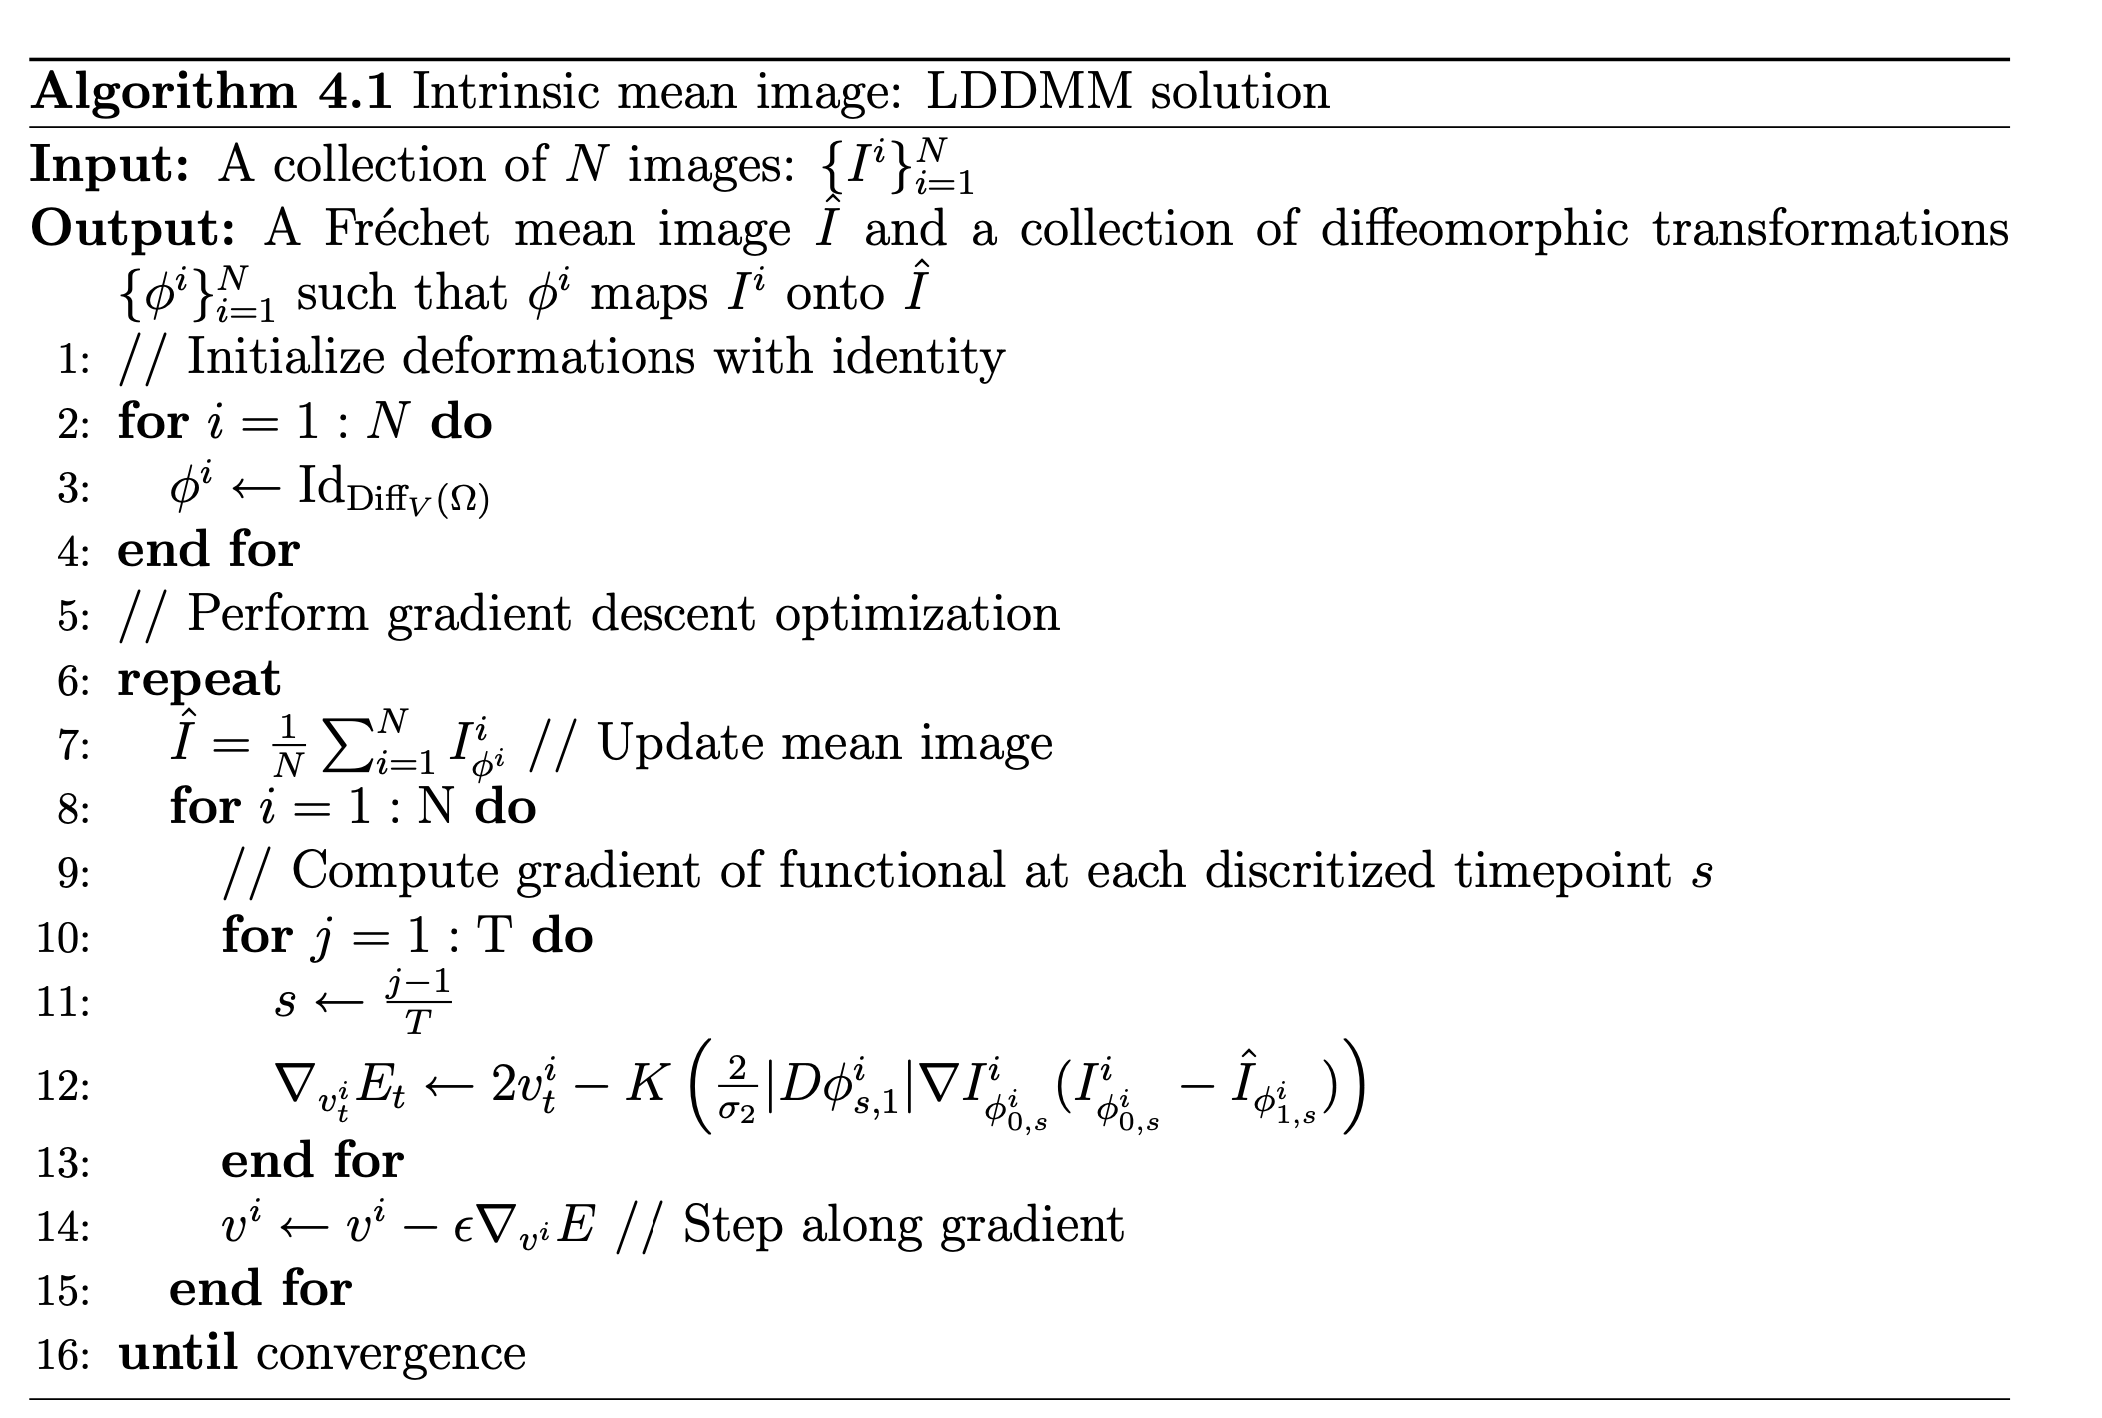